In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from classy import Class
from pybird.correlator import Correlator

RuntimeError: jaxlib is version 0.1.76, but this version of jax requires version >= 0.3.7.

dev mode, reload the following: 

In [2]:
import importlib, pybird
importlib.reload(pybird.correlator)
from pybird.correlator import Correlator

### Linear cosmology

In [3]:
z = .5

In [4]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': z})
M.compute()

In [5]:
kk = np.logspace(-5, 1, 300)
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) 

from scipy.interpolate import interp1d
ipk_lin = interp1d(kk, pk_lin, kind='cubic')

D1, f1 = M.scale_independent_growth_factor(z), M.scale_independent_growth_factor_f(z), 
A_s, Omega0_m = 1e-10 * np.exp(cosmo['ln10^{10}A_s']), M.Omega0_m()

cosmo_lin = {'kk': kk, 'pk_lin': pk_lin, 'f': f1, } # 'D': D1, 'z': z, 'Omega0_m': Omega0_m}

### PyBird benchmark

Loading some fiducial EFT parameters for testing

In [6]:
outdir = os.path.join(os.path.expanduser('~'), 'Documents', 'github', 'pybird', 'data', 'eftboss', 'out')
with open(os.path.join(outdir, 'fit_boss_onesky_pk_wc_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_params = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}
print (eft_params)

{'b1': 1.9536, 'c2': 0.5865, 'c4': 0.0, 'b3': -0.3595, 'cct': 0.1821, 'cr1': -0.8417, 'cr2': -0.808, 'ce0': 1.4954, 'ce1': 0.0, 'ce2': -1.6292, 'b2': 0.4147, 'b4': 0.4147}


Setting PyBird correlator class in normal mode for benchmark

In [7]:
import importlib, pybird
importlib.reload(pybird.correlator)
from pybird.correlator import Correlator

In [8]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 2, 'kmax': 0.3, 
       'with_resum': False, # 'with_bias': True, 
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 
       'eft_basis': 'eftoflss', 'with_stoch': True}) 

# cosmo_lin.update({'bias': eft_params})

Exception: Please specify a data point array 'xdata'.

internal PyBird k array on which the predictions is computed (as we do not specify option `'xdata'`)

In [9]:
k0 = N.co.k

AttributeError: 'Correlator' object has no attribute 'co'

Computation in normal mode for benchmark

In [10]:
N.compute(cosmo_lin) 
bpk_0 = N.get(eft_params)

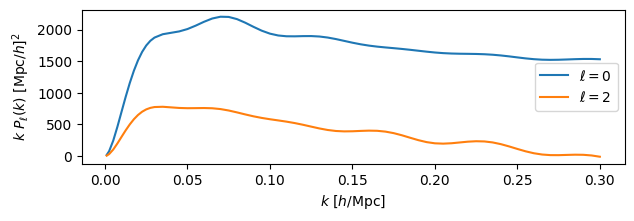

In [11]:
plt.figure(figsize=(7,2))
for i in range(2): plt.plot(k0, k0 * bpk_0[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

# v0.2.1

### kmin < 0.001

In [12]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 2, 'kmax': 0.3, 'kmin': 1e-4,
       'with_resum': False, 
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 
       'eft_basis': 'eftoflss', 'with_stoch': True}) 

N.compute(cosmo_lin) 
k1 = N.co.k
bpk_1 = N.get(eft_params)

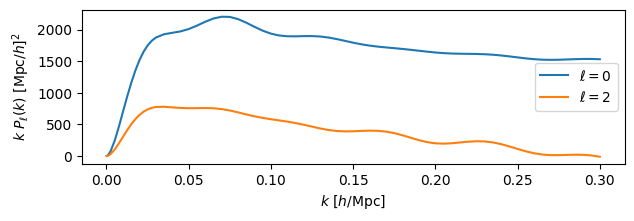

In [13]:
plt.figure(figsize=(7,2))
for i in range(2): plt.plot(k1, k1 * bpk_1[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

In [14]:
plt.figure(figsize=(7,2))
for i in range(2): 
    plt.plot(k0, bpk_0[i], 'k')
    plt.plot(k1, bpk_1[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$P_\ell(k) \ [{\rm Mpc}/h]^3$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

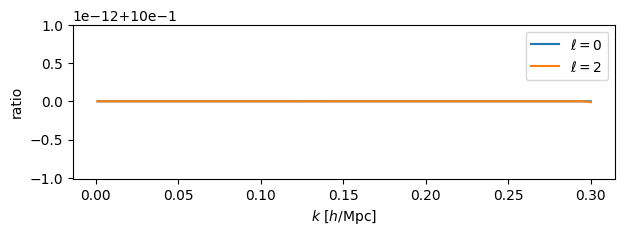

In [15]:
plt.figure(figsize=(7,2))
for i in range(2): plt.plot(k0, bpk_1[i, N.co.id_kstable:]/bpk_0[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'ratio')
plt.legend()
plt.show()

### Differentiable likelihood with JAX

In [ ]:
import importlib, pybird
importlib.reload(pybird.correlator)
from pybird.correlator import Correlator